### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import plotly.express as px

import copy
import seaborn as sns
import os
from scipy import stats
import datetime

import sqlite3 as sqlite
from sqlalchemy import create_engine
%matplotlib inline

In [2]:
data_path = '/mnt/d/lighthouse/Midterm_data/'

In [3]:
# 3035 rows × 25 columns, 63 unique carrier (22)
fuel_comsumption = pd.read_csv(data_path + 'fuel_comsumption.csv', header = 0)

# 2350497 rows × 38 columns, 377 unique carrier (28)
passengers = pd.read_csv(data_path + 'passengers.csv', header = 0)

# 10770229 rows × 33 columns, 28 unique carrier (28)
flights_cleaned = pd.read_csv(data_path + 'flights_cleaned.csv', header = 0)
flights_cleaned.drop('Unnamed: 0', axis =1, inplace = True)

# 15605076 rows × 30 columns, 28 unique carrier (28)
flights = pd.read_csv(data_path + 'flights_original_column_dropped.csv', header = 0)
flights.drop('Unnamed: 0', axis =1, inplace = True)

# Part 1

In [246]:
# (6886231, 30)
flights_part_1 = copy.deepcopy(flights[((flights['dep_delay']>0) & (flights['dep_delay']<1500)) | ((flights['arr_delay']>0) & (flights['arr_delay']<1500))])
flights_part_1 = flights_part_1[flights_part_1['dep_delay']<=1500]
flights_part_1_dep = copy.deepcopy(flights_part_1[flights_part_1['dep_delay']>0])
flights_part_1_arr = copy.deepcopy(flights_part_1[flights_part_1['arr_delay']>0])

Text(0.5, 1.0, 'departure without extreme outlier')

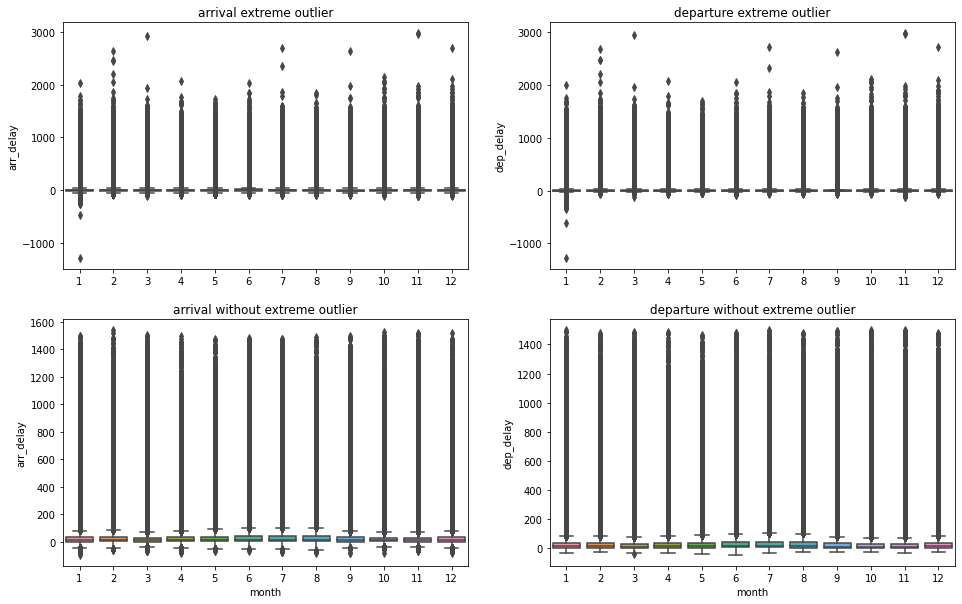

In [94]:
fig, ax = plt.subplots(2,2,figsize=(16,10))
sns.boxplot(x="month", y="arr_delay", data=flights, ax=ax[0][0])
sns.boxplot(x="month", y="dep_delay", data=flights,ax=ax[0][1])
sns.boxplot(x="month", y="arr_delay", data=flights_part_1, ax=ax[1][0])
sns.boxplot(x="month", y="dep_delay", data=flights_part_1,ax=ax[1][1])
ax[0][0].set_xlabel('')
ax[0][1].set_xlabel('')
ax[0][0].set_title('arrival extreme outlier')
ax[0][1].set_title('departure extreme outlier')
ax[1][0].set_title('arrival without extreme outlier')
ax[1][1].set_title('departure without extreme outlier')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_10_part_1_outliers.png')

In [247]:
# overall delay
part_1_sum = flights_part_1.groupby(['op_unique_carrier','month']).sum()[['dep_delay','arr_delay']]
part_1_sum.reset_index(inplace = True)
# departure delays
part_1_dep_sum = flights_part_1_dep.groupby(['op_unique_carrier','month']).sum()[['dep_delay','arr_delay']]
part_1_dep_sum.reset_index(inplace = True)
# arrival delays
part_1_arr_sum = flights_part_1_arr.groupby(['op_unique_carrier','month']).sum()[['dep_delay','arr_delay']]
part_1_arr_sum.reset_index(inplace = True)

In [249]:
part_1_sum_table = part_1_sum.groupby('op_unique_carrier').mean()
part_1_dep_table = part_1_dep_sum.groupby('op_unique_carrier').mean()
part_1_arr_table = part_1_arr_sum.groupby('op_unique_carrier').mean()
part_1_sum_table.drop('month', axis = 1, inplace = True)
part_1_dep_table.drop('month', axis = 1, inplace = True)
part_1_arr_table.drop('month', axis = 1, inplace = True)
part_1_arr_table

,dep_delay,arr_delay
op_unique_carrier,,
9E,5.593442e+05,6.079161e+05
9K,1.488600e+03,1.784200e+03
AA,1.954487e+06,2.193733e+06
AS,3.138022e+05,4.202922e+05
AX,2.747826e+05,3.037312e+05
B6,9.609048e+05,1.013650e+06
C5,2.377812e+05,2.569388e+05
CP,2.064548e+05,2.286210e+05
DL,1.529171e+06,1.664674e+06


# Part 2

In [217]:
flights_part_2 = copy.deepcopy(flights)

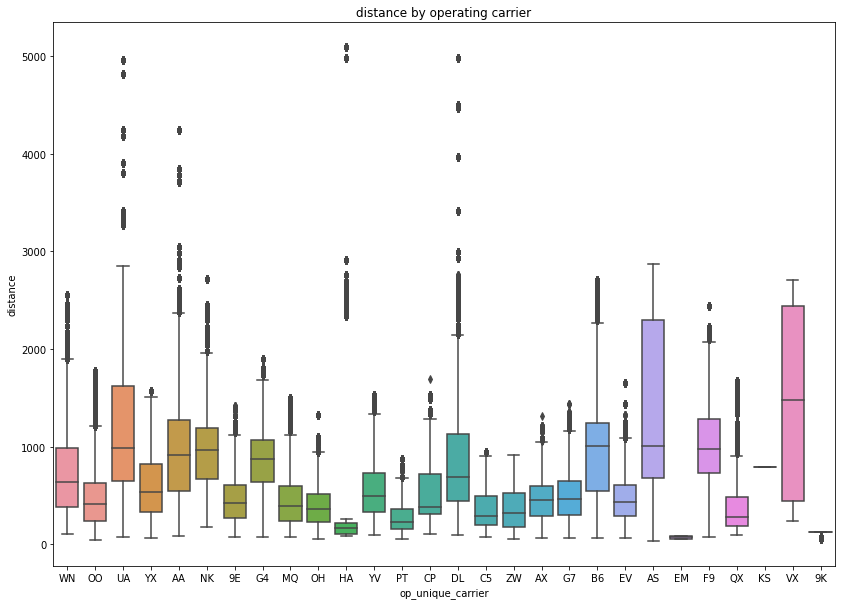

In [109]:
fig, ax = plt.subplots(figsize=(14,10))
sns.boxplot(x="op_unique_carrier", y="distance", data=flights)
ax.set_title('distance by operating carrier')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_10_part_2_dist_carrier.png')

In [218]:
flights_part_2 = flights_part_2[['op_unique_carrier', 'distance', 'month']]
flights_part_2

,op_unique_carrier,distance,month
0,WN,1044,3
1,WN,1044,3
2,WN,1044,3
3,WN,904,3
4,WN,1155,3
...,...,...,...
15605071,WN,689,3
15605072,WN,1489,3
15605073,WN,1482,3
15605074,WN,1044,3


In [219]:
part_2_dist_sum = flights_part_2.groupby(['op_unique_carrier','month']).sum()
part_2_dist_sum.reset_index(inplace = True)
part_2_dist_sum

,op_unique_carrier,month,distance
0,9E,1,17174487
1,9E,2,16160408
2,9E,3,19063894
3,9E,4,18820914
4,9E,5,19183261
...,...,...,...
315,ZW,8,6380040
316,ZW,9,6165525
317,ZW,10,6551887
318,ZW,11,6104967


In [220]:
part_2_dist_table = part_2_dist_sum.groupby('op_unique_carrier').sum()
part_2_dist_table.drop('month', axis = 1, inplace = True)
part_2_dist_table

,distance
op_unique_carrier,
9E,227216442
9K,194016
AA,1834510729
AS,662016945
AX,70247109
B6,646131860
C5,36672472
CP,103203760
DL,1722972795


# Part 3

In [139]:
flights_part_3 = copy.deepcopy(passengers)

In [140]:
flight_carrier_list = ['9E', '9K', 'AA', 'AS', 'AX', 'B6', 'C5', 'CP', 'DL', 'EM', 'EV',
       'F9', 'G4', 'G7', 'HA', 'KS', 'MQ', 'NK', 'OH', 'OO', 'PT', 'QX',
       'UA', 'VX', 'WN', 'YV', 'YX', 'ZW']

In [142]:
flights_part_3  = flights_part_3[flights_part_3['unique_carrier'].isin(flight_carrier_list)]
flights_part_3 

,departures_scheduled,departures_performed,payload,seats,passengers,freight,mail,distance,ramp_to_ramp,air_time,...,dest_country,dest_country_name,aircraft_group,aircraft_type,aircraft_config,year,month,distance_group,class,data_source
1199,0,1,37400,150,135,0,0,2517,355,337,...,US,United States,6,694,1,2015,5,6,F,DU
1200,0,1,37400,150,121,0,0,1221,304,199,...,US,United States,6,694,1,2015,5,3,F,DU
1201,0,1,37400,150,126,0,0,1374,293,263,...,US,United States,6,694,1,2015,5,3,F,DU
1202,0,1,26200,100,100,0,0,787,136,115,...,US,United States,6,678,1,2015,5,2,F,DU
1203,0,1,37400,150,140,0,0,849,280,181,...,US,United States,6,694,1,2015,5,2,F,DU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347748,0,3,111567,438,100,0,0,189,165,99,...,US,United States,6,694,1,2015,5,1,F,DU
2347749,0,1,37189,149,123,0,0,1184,169,153,...,US,United States,6,694,1,2015,5,3,F,DU
2347750,0,1,37189,149,117,0,0,1184,190,151,...,US,United States,6,694,1,2015,5,3,F,DU
2347751,0,1,37822,119,75,0,0,954,143,129,...,US,United States,6,698,1,2015,5,2,F,DU


Text(0.5, 1.0, 'passengers by operating carrier')

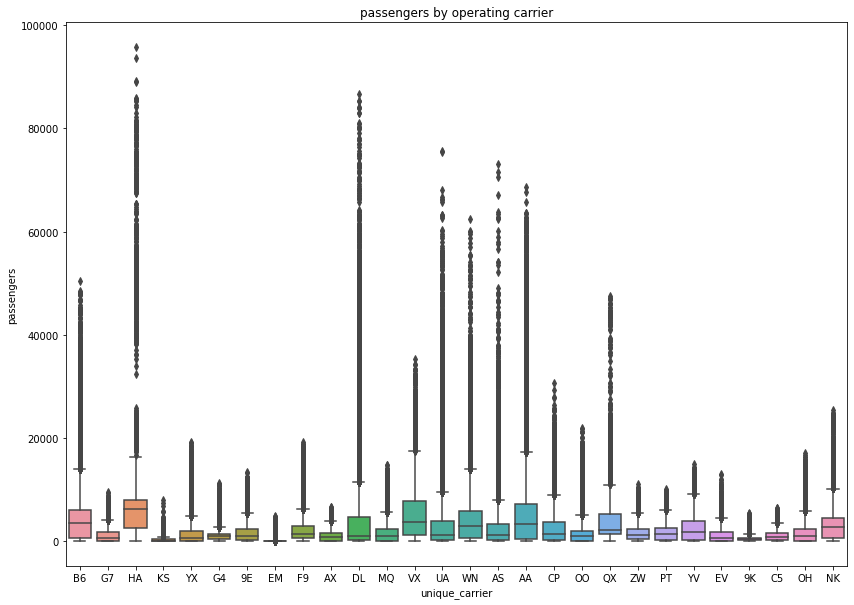

In [138]:
fig, ax = plt.subplots(figsize=(14,10))
sns.boxplot(x="unique_carrier", y="passengers", data=flights_part_3)
ax.set_title('passengers by operating carrier')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_10_part_3_passenger_carrier.png')

In [143]:
flights_part_3 = flights_part_3[['unique_carrier', 'passengers', 'month']]
flights_part_3

,unique_carrier,passengers,month
1199,B6,135,5
1200,B6,121,5
1201,B6,126,5
1202,B6,100,5
1203,B6,140,5
...,...,...,...
2347748,VX,100,5
2347749,VX,123,5
2347750,VX,117,5
2347751,VX,75,5


In [144]:
part_3_pass_sum = flights_part_3.groupby(['unique_carrier','month']).sum()
part_3_pass_sum.reset_index(inplace = True)
part_3_pass_sum

,unique_carrier,month,passengers
0,9E,1,4108407
1,9E,2,3966921
2,9E,3,5218993
3,9E,4,5119185
4,9E,5,5398542
...,...,...,...
331,ZW,8,2050855
332,ZW,9,1875330
333,ZW,10,2063660
334,ZW,11,1871280


In [146]:
part_3_pass_table = part_3_pass_sum.groupby('unique_carrier').sum()
part_3_pass_table.drop('month', axis = 1, inplace = True)
part_3_pass_table

,passengers
unique_carrier,
9E,61996211
9K,2997461
AA,715203891
AS,145210038
AX,16433668
B6,198872059
C5,8275002
CP,30269658
DL,742511388


# Part 4

In [212]:
len(set(fuel_comsumption['unique_carrier'].unique())&set(passengers['unique_carrier'].unique()))

62

In [154]:
flights_part_4 = copy.deepcopy(fuel_comsumption)

In [211]:
fuel_comsumption['total_gallons']

0            3000.0
1          210112.0
2               0.0
3               0.0
4          284362.0
           ...     
3030      2531738.0
3031            0.0
3032            0.0
3033        21048.0
3034    175889193.0
Name: total_gallons, Length: 3035, dtype: float64

In [149]:
flight_carrier_list = ['9E', '9K', 'AA', 'AS', 'AX', 'B6', 'C5', 'CP', 'DL', 'EM', 'EV',
       'F9', 'G4', 'G7', 'HA', 'KS', 'MQ', 'NK', 'OH', 'OO', 'PT', 'QX',
       'UA', 'VX', 'WN', 'YV', 'YX', 'ZW']

In [165]:
flights_part_4  = flights_part_4[flights_part_4['unique_carrier'].isin(flight_carrier_list)]
flights_part_4 = flights_part_4[flights_part_4['total_cost']<900000000]

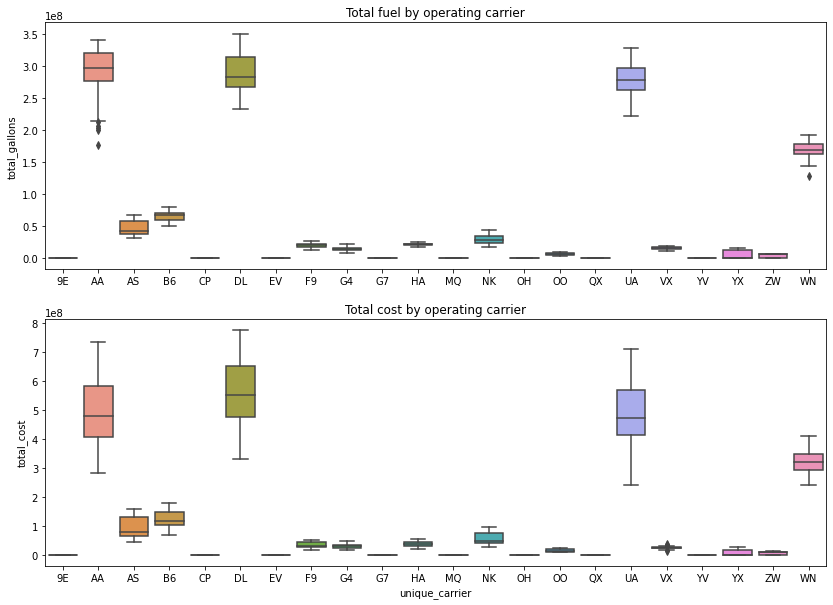

In [169]:
fig, ax = plt.subplots(2,figsize=(14,10))
sns.boxplot(x="unique_carrier", y="total_gallons", data=flights_part_4, ax=ax[0])
sns.boxplot(x="unique_carrier", y="total_cost", data=flights_part_4, ax=ax[1])
ax[0].set_title('Total fuel by operating carrier')
ax[1].set_title('Total cost by operating carrier')
ax[0].set_xlabel('')
plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_10_part_4_fuel_carrier.png')

In [170]:
flights_part_4 = flights_part_4[['unique_carrier', 'total_gallons', 'total_cost','month']]
flights_part_4

,unique_carrier,total_gallons,total_cost,month
8,9E,0.0,0.0,1
10,AA,282748633.0,317344085.0,1
12,AS,37667477.0,47152571.0,1
13,B6,60623708.0,70537499.0,1
14,CP,0.0,0.0,1
...,...,...,...,...
3024,QX,0.0,0.0,12
3027,UA,288756890.0,569473976.0,12
3032,YV,0.0,0.0,12
3033,YX,21048.0,50043.0,12


In [171]:
part_4_fuel_sum = flights_part_4.groupby(['unique_carrier','month']).sum()
part_4_fuel_sum.reset_index(inplace = True)
part_4_fuel_sum

,unique_carrier,month,total_gallons,total_cost
0,9E,1,0.0,0.0
1,9E,2,0.0,0.0
2,9E,3,0.0,0.0
3,9E,4,0.0,0.0
4,9E,5,0.0,0.0
...,...,...,...,...
259,ZW,8,13492766.0,22035817.0
260,ZW,9,6661501.0,10977757.0
261,ZW,10,6824293.0,10744013.0
262,ZW,11,6396823.0,9853341.0


In [172]:
part_4_fuel_table = part_4_fuel_sum.groupby('unique_carrier').sum()
part_4_fuel_table.drop('month', axis = 1, inplace = True)
part_4_fuel_table

,total_gallons,total_cost
unique_carrier,,
9E,0.000000e+00,0.000000e+00
AA,1.663489e+10,2.853022e+10
AS,2.678455e+09,5.301448e+09
B6,3.767060e+09,7.075583e+09
CP,0.000000e+00,0.000000e+00
DL,1.600320e+10,3.087020e+10
EV,2.678243e+06,7.222075e+06
F9,1.125294e+09,1.929598e+09
G4,8.497621e+08,1.659141e+09


# merging table

In [221]:
# (28, 3)
# part_1_sum_table
# part_1_arr_table
# part_1_dep_table

#(28, 1)
# part_2_dist_table

#(28, 1)
# part_3_pass_table

# (22, 2)
# part_4_fuel_table

In [255]:
# (28, 3)
merge_12_arr = pd.merge(part_1_arr_table, part_2_dist_table, left_index=True, right_index=True)
merge_12_dep = pd.merge(part_1_dep_table, part_2_dist_table, left_index=True, right_index=True)
merge_12_sum = pd.merge(part_1_sum_table, part_2_dist_table, left_index=True, right_index=True)
# (28, 4)
merge_123_arr = pd.merge(merge_12_arr, part_3_pass_table, left_index=True, right_index=True)
merge_123_dep = pd.merge(merge_12_dep, part_3_pass_table, left_index=True, right_index=True)
merge_123_sum = pd.merge(merge_12_sum, part_3_pass_table, left_index=True, right_index=True)
# (22, 6)
merge_1234_arr = pd.merge(merge_123_arr, part_4_fuel_table, left_index=True, right_index=True)
merge_1234_dep = pd.merge(merge_123_dep, part_4_fuel_table, left_index=True, right_index=True)
merge_1234_sum = pd.merge(merge_123_sum, part_4_fuel_table, left_index=True, right_index=True)

In [257]:
# converitng miles to km 
merge_1234_arr['distance'] = merge_1234_arr['distance']*1.60934
merge_1234_dep['distance'] = merge_1234_dep['distance']*1.60934
merge_1234_sum['distance'] = merge_1234_sum['distance']*1.60934

# dropping carrier with 0 fuel
merge_1234_arr = merge_1234_arr[merge_1234_arr['total_gallons']>0]
merge_1234_dep = merge_1234_dep[merge_1234_dep['total_gallons']>0]
merge_1234_sum = merge_1234_sum[merge_1234_sum['total_gallons']>0]

# calculating fuel/cost per passenger per km
merge_1234_arr['fuel_per_passenger_per_km'] = (merge_1234_arr['total_gallons']/merge_1234_arr['passengers'])/merge_1234_arr['distance']
merge_1234_arr['cost_per_passenger_per_km'] = (merge_1234_arr['total_cost']/merge_1234_arr['passengers'])/merge_1234_arr['distance']
merge_1234_dep['fuel_per_passenger_per_km'] = (merge_1234_dep['total_gallons']/merge_1234_dep['passengers'])/merge_1234_dep['distance']
merge_1234_dep['cost_per_passenger_per_km'] = (merge_1234_dep['total_cost']/merge_1234_dep['passengers'])/merge_1234_dep['distance']
merge_1234_sum['fuel_per_passenger_per_km'] = (merge_1234_sum['total_gallons']/merge_1234_sum['passengers'])/merge_1234_sum['distance']
merge_1234_sum['cost_per_passenger_per_km'] = (merge_1234_sum['total_cost']/merge_1234_sum['passengers'])/merge_1234_sum['distance']

# reset index and columns
merge_1234_arr.reset_index(inplace = True)
merge_1234_arr.columns = ['carrier', 'dep_delay', 'arr_delay', 'distance', 'passengers','total_gallons', 'total_cost', 'fuel_per_passenger_per_km','cost_per_passenger_per_km']
merge_1234_dep.reset_index(inplace = True)
merge_1234_dep.columns = ['carrier', 'dep_delay', 'arr_delay', 'distance', 'passengers','total_gallons', 'total_cost', 'fuel_per_passenger_per_km','cost_per_passenger_per_km']
merge_1234_sum.reset_index(inplace = True)
merge_1234_sum.columns = ['carrier', 'dep_delay', 'arr_delay', 'distance', 'passengers','total_gallons', 'total_cost', 'fuel_per_passenger_per_km','cost_per_passenger_per_km']

In [275]:
# sorting by dep_delay time
merge_1234_arr = merge_1234_arr.sort_values(by='arr_delay', ascending = False)
merge_1234_dep = merge_1234_dep.sort_values(by='dep_delay', ascending = False)
merge_1234_sum = merge_1234_sum.sort_values(by='arr_delay', ascending = False)
merge_1234_sum

,carrier,dep_delay,arr_delay,distance,passengers,total_gallons,total_cost,fuel_per_passenger_per_km,cost_per_passenger_per_km
9,OO,1.956710e+06,2.071116e+06,1.234401e+09,178848860,3.817040e+08,8.201462e+08,1.728958e-09,3.714915e-09
0,AA,2.043601e+06,2.064548e+06,2.952351e+09,715203891,1.663489e+10,2.853022e+10,7.878108e-09,1.351161e-08
12,WN,2.669161e+06,2.061373e+06,3.192198e+09,803499970,9.599040e+09,1.816020e+10,3.742416e-09,7.080189e-09
10,UA,1.489333e+06,1.557120e+06,2.362968e+09,533886775,1.595691e+10,2.786589e+10,1.264858e-08,2.208849e-08
3,DL,1.640374e+06,1.500147e+06,2.772849e+09,742511388,1.600320e+10,3.087020e+10,7.772802e-09,1.499374e-08
2,B6,9.934262e+05,9.723532e+05,1.039846e+09,198872059,3.767060e+09,7.075583e+09,1.821628e-08,3.421523e-08
13,YX,6.047508e+05,6.918164e+05,5.994991e+08,81202458,2.870984e+08,4.294171e+08,5.897569e-09,8.821078e-09
4,EV,4.877803e+05,5.353943e+05,2.435354e+08,79135585,2.678243e+06,7.222075e+06,1.389684e-10,3.747382e-10
8,NK,4.233798e+05,4.225871e+05,6.088224e+08,127529568,1.663308e+09,3.211993e+09,2.142255e-08,4.136881e-08
5,F9,4.228943e+05,4.059736e+05,4.167640e+08,87767317,1.125294e+09,1.929598e+09,3.076403e-08,5.275260e-08


# plotting the result

### arrival_delays

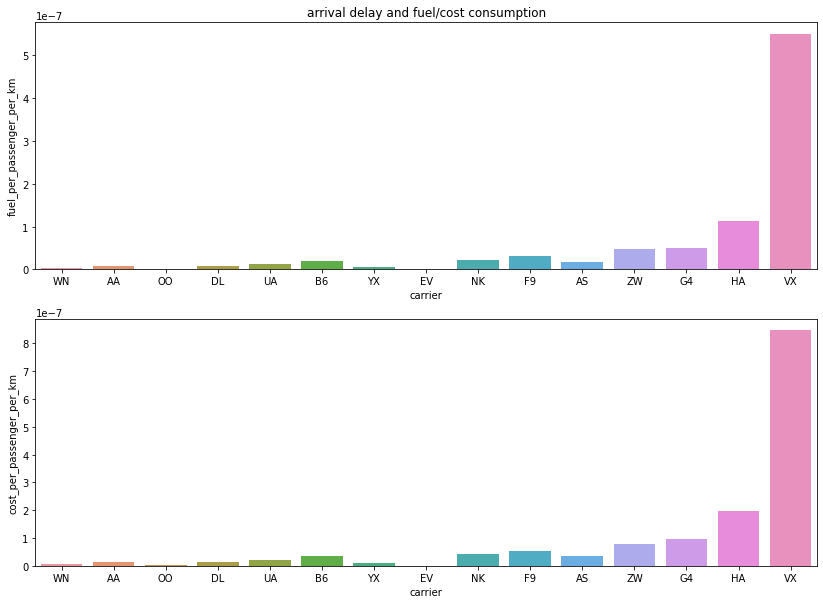

In [272]:
fig, ax = plt.subplots(2,figsize=(14,10))
sns.barplot(merge_1234_arr['carrier'],merge_1234_arr['fuel_per_passenger_per_km'], ax = ax[0])
sns.barplot(merge_1234_arr['carrier'],merge_1234_arr['cost_per_passenger_per_km'], ax = ax[1])
ax[0].set_title('arrival delay and fuel/cost consumption')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_10_part_4_arr_result.png')

### departure_delays

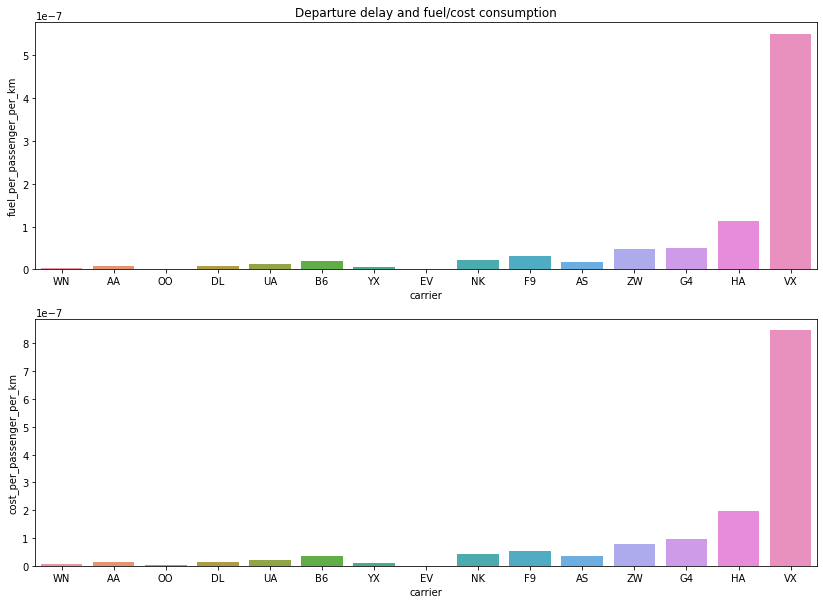

In [273]:
fig, ax = plt.subplots(2,figsize=(14,10))
sns.barplot(merge_1234_dep['carrier'],merge_1234_dep['fuel_per_passenger_per_km'], ax = ax[0])
sns.barplot(merge_1234_dep['carrier'],merge_1234_dep['cost_per_passenger_per_km'], ax = ax[1])
ax[0].set_title('Departure delay and fuel/cost consumption')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_10_part_4_dep_result.png')

### All delays

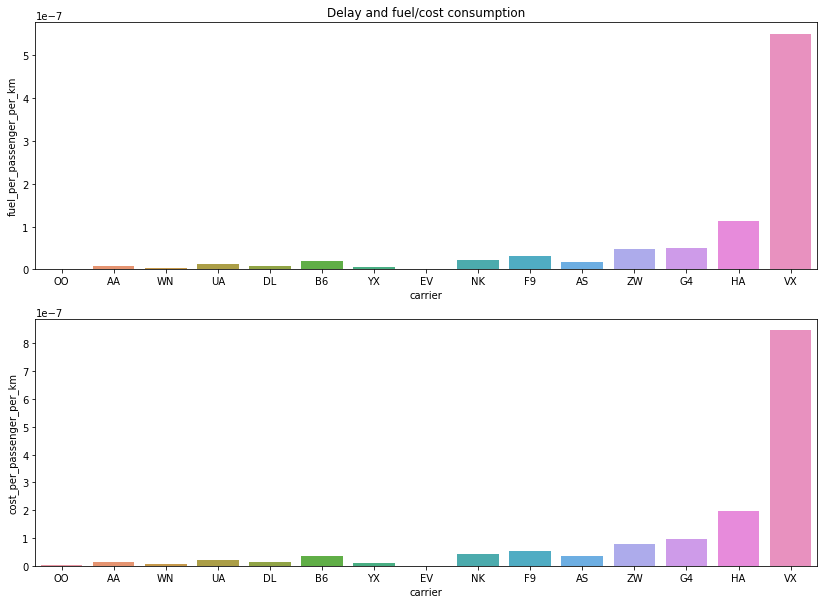

In [274]:
fig, ax = plt.subplots(2,figsize=(14,10))
sns.barplot(merge_1234_sum['carrier'],merge_1234_sum['fuel_per_passenger_per_km'], ax = ax[0])
sns.barplot(merge_1234_sum['carrier'],merge_1234_sum['cost_per_passenger_per_km'], ax = ax[1])
ax[0].set_title('Delay and fuel/cost consumption')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_10_part_4_sum_result.png')

## air_carrier with with lower delay time tend to need more fuel and cost per customer per km